### Levinsion Durbin Recursion

Author: Arun Prakash, mail:arunprakash.ece@kongu.ac.in

 * We have many methods for solving system of Equations of the form $Ax=b$. However, when $A$ is a Toeplitz matrix, using Levinsion-Durbin Recursion algorithm takes much lesser computation.
 * These type of matrices arises in all-pole modelling of a random process (Recall, Pade and Prony Approximation)
 * The sequential steps involved in obtaining a solution recursively are as follows
     1. Initialization: $ap[0]=1, \epsilon=r_x[0]$
     2. The filter order is $p = len(rx)$
     3. for **j:0,1,..p-1:** <br> 

      i.)   $\gamma_j =r_x(j+1)+\sum_{i=1}^{j}a_p(i)r_x(j+1-i)$ <br>
      ii.)  $\Gamma_{j+1} = - \frac{\gamma_j}{\epsilon_j}$, $\epsilon_{j+1}=\epsilon_j(1-\Gamma_{j+1}^2)$ <br>
      iii.) Update filter coefficients upto $j^{th}$ order. <br>
      iv.) Filter coefficient at $j+1$ = $\Gamma_{j+1}$ <br>
     
 * Don't afriad of the above equations. Try to vectorize the code. (Ofcourse, use paper and pen before start writing the code)


In [1]:
import numpy as np
from scipy import signal as sig
from  scipy import linalg as lalg
from matplotlib import pyplot as plt

**Let us start with an example and solve the problem with the function built-in with scipy**

In [2]:
rx = np.array([1,0.5,0.5,0.25,0.1,0.05])
p = len(rx)-1
rx_toe = lalg.toeplitz(rx[0:p])
right = -1*rx[1:]
print(rx_toe)

[[1.   0.5  0.5  0.25 0.1 ]
 [0.5  1.   0.5  0.5  0.25]
 [0.5  0.5  1.   0.5  0.5 ]
 [0.25 0.5  0.5  1.   0.5 ]
 [0.1  0.25 0.5  0.5  1.  ]]


In [3]:
c = rx_toe[:,0] # get the coloumn of rx
r = c # row =  col due to symmetry
ap_k = lalg.solve_toeplitz((c,r), right)
ap_k = np.insert(ap_k,0,1)
print(ap_k)

[ 1.         -0.35896474 -0.44493623  0.07325581  0.19377344 -0.0363841 ]


**That's great, but implementing the algorithm based on our understanding is always fun and also gives us a sense of satisfication**. Let us code..

In [4]:
def levinsion(rx, verbose=False):
    p = len(rx)-1

    # initializatio 
    ap = np.array([1])
    epsilon= rx[0]
    
    
    for j in range(0,p):   
        
        ap = np.insert(ap,len(ap),0)
        #print(ap)
        if j==0:
            gamma = rx[1]
        else:
            gamma = np.sum(rx[j+1:0:-1]*ap[0:j+1])       
        Gamma = -1*(gamma/epsilon)
        epsilon = epsilon*(1-np.abs(Gamma)**2)         
        ap = ap+(Gamma*ap[-1::-1])
        ap[j+1] = Gamma

        if verbose:
            print('Iteration:{0} \t gamma:{1} \t Gamma:{2} \t epsilon:{3} \t ap:{4}'.format(j,gamma,Gamma,epsilon,ap))
    return ap,np.sqrt(epsilon)

In [5]:
ap,epsilon = levinsion(rx,verbose=False)    
print('The Denominator Coeff: \n ',ap)
print('The Numerator Coeffi: \n',epsilon)


The Denominator Coeff: 
  [ 1.         -0.35896474 -0.44493623  0.07325581  0.19377344 -0.0363841 ]
The Numerator Coeffi: 
 0.796191940050482


**Generate a Process**

 * Let us generate a well known first order AR(1) process by filtering a white noise using the following filter transfer function $$ H(z) = \frac{1}{1-\alpha z^{-1}}$$. Assuming the white noise have unit variance, it produces autocorrelation relation $$ r_x(k) = \frac{1}{1-\alpha^2}\alpha^{|k|}$$
 
**Estimate the process**

 * Given the sample realizations of the process $x(n)$, our first step is to compute the autocorrelation of the process which takes $N(p+1)$ comptations.
 * Then, we make use of LD recursion to estimate the filter coefficients that generated the process (Remember, we were not given the actual filter order that generated the process).

In [6]:
N = 1000
vn = np.random.randn(N)
num = np.array([1])
den = np.array([1,-0.5])
xn = sig.lfilter(num,den,vn)
k = 10 # lags
alpha = 0.5
rx_actual = (1/(1-(alpha)**2))*np.power(alpha,np.arange(k))

Since we know that the process is **Ergodic (Ensemble average = Time average)**, we can use the following equation to compute the sample autocorrelation of the sequence $x(n)$ <br>

$$ \tilde{r}_x(k) = \frac{1}{N} \sum_{n=0}^{N-1} x(n)x(n-k)$$
which is convolution sum formula. We can either implement the formula or make use of **np.correlate** function comes with numpy.

In [7]:

xnk = np.insert(xn,[0],np.zeros(k)) # append zeros for negative indexing
rx = np.zeros(k) # initialization
m = k# start index of xnk from m-k
l = len(xnk) # ending index for xnk during slicing operation
for lag in np.arange(k):
    rx[lag] = np.dot(xn,xnk[m-lag:l-lag])
rx = (1/N)*rx

In [8]:
# using numpy inbuilt
# rx = (1/N)*np.correlate(xn,xn,mode='same')
# rx = rx[(N/2):(N/2)+k]

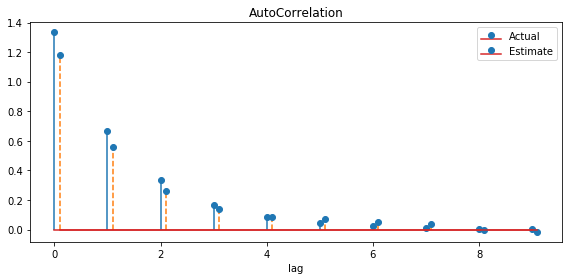

In [9]:
n = np.arange(k)+0.1 # just move a plot to little right
fig,ax = plt.subplots(1,1,figsize=(8,4))
ax.stem(rx_actual,use_line_collection=True,label='Actual')
ax.stem(n,rx,linefmt='C1--',use_line_collection=True,label='Estimate')
ax.set_xlabel('lag')
ax.set_title('AutoCorrelation')
ax.legend()
fig.tight_layout()

In [10]:
num,den = levinsion(rx)
print(num,den)

[ 1.00000000e+00 -4.73271902e-01  1.45620880e-02 -1.47647648e-02
 -6.01169378e-03 -1.85446936e-02 -6.53561550e-04 -2.02218054e-02
  3.11182939e-02  2.14742420e-03] 0.9568310873993382


**What Next?**

 * Let us buid a filter with the obtained system transfer function and pass the white noise $v(n)$ through it.
 * Compute the MSE
 * Since we know that it is AR(1) model that generated the process, it would be interesting to see how the model error **Changes** as we increase the model order.

In [11]:
xn_estimate = sig.lfilter(num,den,vn)

In [12]:
mse = (1/N)*np.sum((xn-xn_estimate)**2)

In [13]:
# AR(1,2,3,...,p)
p = 10
mse = []
for k in np.arange(p):
    num,den = levinsion(rx[0:k+2])
    #print(num,den)
    xn_estimate = sig.lfilter(num,den,vn)
    mse.append((1/N)*np.sum((xn-xn_estimate)**2))

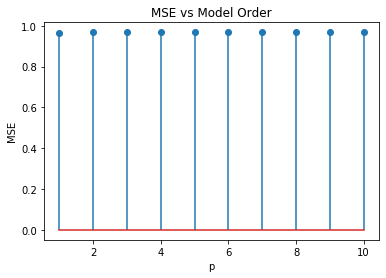

In [14]:
n=np.arange(1,11)
plt.stem(n,mse,use_line_collection=True)
plt.xlabel('p')
plt.ylabel('MSE')
plt.title('MSE vs Model Order')
plt.show()

**Surprise!**

 * The model error doesn't change, you can justify it by looking at the numerator and denominator coefficients displayed in the cell below as the model order increases.
 
 * The denominator remains 0.98 (Actual=1), ap[1] = -0.48 (Actual=-0.5), the remaining coefficients contributes less.

In [15]:
# AR(1,2,3,...,p)
p = 4
for k in np.arange(p):
    num,den = levinsion(rx[0:k+2])
    print('Order:{0},\t Num:{1},\t Den{2}'.format(k,num,den))

Order:0,	 Num:[ 1.         -0.47168503],	 Den0.9578635843901845
Order:1,	 Num:[ 1.         -0.47378695  0.00445619],	 Den0.9578540738875962
Order:2,	 Num:[ 1.         -0.47388117  0.01447359 -0.02114326],	 Den0.9576399517156942
Order:3,	 Num:[ 1.         -0.47356164  0.01425486 -0.01398166 -0.01511264],	 Den0.9575305868706292
